In [ ]:
import csv
from collections import defaultdict
from decimal import Decimal
import numpy as np
import matplotlib.pyplot as plt
import time

start_read = time.time()
peptide_to_direction = {}
peptide_to_gene_symbol = {}
with open("peptides.csv") as peptidefile:
    peptide_reader = csv.reader(peptidefile)
    next(peptide_reader)
    for row in peptide_reader:
        peptide_to_direction[row[0]] = row[1]
        peptide_to_gene_symbol[row[0]] = row[2].upper()


kinase_to_scores_read = {}
kinase_to_motifs = {}
kinase_to_direction = {}
kinase_peptide_to_dot_product = {}

with open("bayes_for_colab.csv") as bayesfile:
    bayes_reader = csv.reader(bayesfile)
    next(bayes_reader)
    for row in bayes_reader:
        kinase_to_scores_read[row[0]] = row[1:5]
        kinase_to_motifs[row[0]] = [val == "1" for val in row[5:13] ]
        kinase_to_direction[row[0]] = row[-1]

with open("dot_product.csv") as dot_product:
    dot_product_reader = csv.reader(dot_product)
    kinases = list(next(dot_product_reader))[1:]
    for row in dot_product_reader:
        peptide = row[0]

        for i, value in enumerate(row[1:]):
            kinase_peptide_to_dot_product[(peptide, kinases[i].upper())] = value

peptides_no_pka = []

with open("peptides_no_rr.csv") as peptides_no_rr:
    peptides_no_rr_reader = csv.reader(peptides_no_rr)
    next(peptides_no_rr_reader)
    for peptide in peptides_no_rr_reader:
        peptides_no_pka.append(peptide[0])

    peptides_no_pka.append("KGTPTQSPVVGRS")

peptides_unclear = []

with open("peptide_no_map_pka.csv") as peptides_no_map_pka:
    peptides_no_map_pka_reader = csv.reader(peptides_no_map_pka)
    next(peptides_no_map_pka_reader)
    for peptide in peptides_no_map_pka_reader:
        peptides_unclear.append(peptide[0])


print(peptides_unclear)
end_read = time.time()
print(kinase_to_scores_read)
print("TIME TO READ", end_read - start_read)
print(kinase_peptide_to_dot_product)

['PLRKTASEPNLKL', 'KFTRRVSVCAETF', 'SPPPDGSPAATPE', 'RLQDSRSLDGLSG', 'QDTQRRTSMGGTQ', 'LPEQRSSLPQQEL', 'YFKGDHSVGVNGP', 'RHGRSQSLPNSLD', 'ARRNLGSINTELQ']
{'AAK1': ['7.4', '9.8', '28491.79866', '15909.42578'], 'AATK': ['0.2', '2.2', '-', '-'], 'ABL1': ['15.3', '50.1', '4984.757749', '2.447154472'], 'ABL2': ['2.5', '14.4', '52.56289436', '-'], 'ACVR1': ['4', '5.1', '-', '-'], 'ACVR1B': ['2.4', '26.4', '-', '-'], 'ACVR1C': ['0.1', '-', '-', '-'], 'ACVR2A': ['7.5', '49.7', '-', '-'], 'ACVR2B': ['31', '4.9', '-', '-'], 'ACVRL1': ['0.6', '-', '-', '-'], 'ADCK1': ['23.4', '18', '1824.464243', '3975.601778'], 'ADCK2': ['18.5', '8.8', '0', '-'], 'ADCK3': ['', '7.4', '-', '-'], 'ADCK4': ['', '12.8', '-', '-'], 'ADCK5': ['32.7', '27.6', '6827.385517', '839.5625867'], 'ADRBK1': ['', '65.6', '-', '22181.03777'], 'ADRBK2': ['', '-', '-', '8336.120507'], 'AKT1': ['145.5', '246.3', '3909.425163', '84700.92656'], 'AKT2': ['27.5', '40.2', '13868.84628', '16910.24486'], 'AKT3': ['0.4', '48.7', '-', '1482

In [ ]:
# PRE MOTIF
import math

def is_float(string):
    try:
        float(string)
        return True

    except (ValueError, TypeError):
        return False

MIN_MBF = Decimal(0.5)

def get_pre_peptide_probabilities(percentile):
    NUM_PREMOTIF = len(kinase_to_scores_read["MAPK1"])
    starting_probability = Decimal("1") / Decimal(len(kinase_to_scores_read))
    kinase = list(sorted(kinase_to_scores_read))
    kinase_to_probability = {
        kinase: starting_probability
        for kinase in kinase_to_scores_read
    }

    for score_index in range(NUM_PREMOTIF):
        total_joint = Decimal(0)
        kinase_to_joint = {}

        current_scores = []

        for scores in kinase_to_scores_read.values():
            if is_float(scores[score_index]):
                current_scores.append(Decimal(scores[score_index]))
        background_threshold = Decimal(np.percentile(current_scores, Decimal(percentile)))

        for kinase, scores in kinase_to_scores_read.items():
            try:
                score = Decimal(scores[score_index])
                z = score / background_threshold
                mbf = Decimal(1) - Decimal(math.exp(Decimal(-1) * z * z / Decimal(2)))
                norm_mbf = max(MIN_MBF, mbf)
            except:
                norm_mbf = MIN_MBF
            joint = kinase_to_probability[kinase] * norm_mbf
            kinase_to_joint[kinase] = joint
            total_joint += joint


        for kinase, joint in kinase_to_joint.items():
            kinase_to_probability[kinase] = joint / total_joint

    return kinase_to_probability

start_time = time.time()
print("TIME", time.time() - start_time)

TIME 4.696846008300781e-05


[Decimal('0.03903673970391043643906176365'), Decimal('0.04001480850678894372903688709'), Decimal('0.04159468201696431476874355735'), Decimal('0.04280977783236541240887227346'), Decimal('0.04362130645386253769988742466'), Decimal('0.04462222663934631897026796946'), Decimal('0.04571314470586953854640443112'), Decimal('0.04676333835239145042013409854'), Decimal('0.04814887421742250979472153492'), Decimal('0.0493066064862034018771223284'), Decimal('0.0503681945389371964405284522'), Decimal('0.05172649119354212657386859157'), Decimal('0.05349095691106761587557793958'), Decimal('0.05543832277774048918874646566'), Decimal('0.05707685205104619534177935611'), Decimal('0.05880627805128605837335099394'), Decimal('0.06132826159291534561054357932'), Decimal('0.062787376063464642638607985'), Decimal('0.06457081496901312155102008897'), Decimal('0.06617764324330398364962423685'), Decimal('0.06813785763347670479071009074'), Decimal('0.07022861485045981452665656165'), Decimal('0.072512489374160126359881

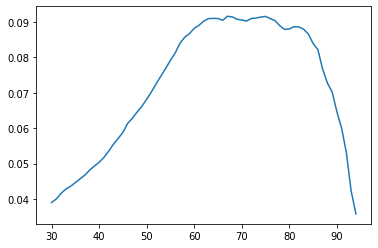

In [ ]:
import math
import copy
from collections import Counter

def calc_kinase_probability_matching_score(kinase_to_probability, kinase_to_matching_scores):
    num_matching = len(next(iter(kinase_to_matching_scores.values())))
    kinase_match_time_start = time.time()

    for score_index in range(num_matching):
        mbf_total = Decimal(0)
        total_joint = Decimal(0)
        kinase_to_joint = {}

        for kinase, scores in kinase_to_matching_scores.items():
            score = scores[score_index]
            score = Decimal(score) if is_float(score) else MIN_MBF

            norm_mbf = score

            mbf_total += norm_mbf
            joint = kinase_to_probability[kinase] * norm_mbf
            total_joint += joint
            kinase_to_joint[kinase] = joint

        for kinase in list(kinase_to_probability):
            kinase_to_probability[kinase] = kinase_to_joint[kinase] / total_joint

    return kinase_to_probability

def calc_kinase_probability_dot_product(kinase_to_probability, percentile, peptide):

    total_joint = Decimal(0)
    kinase_to_joint = {}

    current_scores = []
    kinase_to_score = {}

    for kinase in kinase_to_scores_read:
        score = kinase_peptide_to_dot_product.get((kinase, peptide_to_gene_symbol[peptide]))
        if is_float(score):
            current_scores.append(Decimal(score))
            kinase_to_score[kinase] = Decimal(score)
    background_threshold = Decimal(np.percentile(current_scores, Decimal(percentile))) if current_scores else 1000

    for kinase in kinase_to_scores_read:
        try:
            score = kinase_to_score[kinase]
            z = score / background_threshold
            mbf = Decimal(1) - Decimal(math.exp(Decimal(-1) * z * z / Decimal(2)))
            norm_mbf = max(MIN_MBF, mbf)
        except:
            norm_mbf = MIN_MBF
        joint = kinase_to_probability[kinase] * norm_mbf
        kinase_to_joint[kinase] = joint
        total_joint += joint


    for kinase, joint in kinase_to_joint.items():
        kinase_to_probability[kinase] = joint / total_joint
    return kinase_to_probability

def get_matching_1_mbf(peptide):
    matching_mbf_start = time.time()
    def matches_letter(letter, peptide_letter):
        if letter == "D":
            return peptide_letter in {"D" , "E"}

        if letter == "L":
            return peptide_letter in {"L", "I", "V"}

        if letter == "R":
            return peptide_letter in {"R", "K", "H"}

    kinase_to_matching_scores = {}
    good_match, no_match, bad_match = Decimal(0.9), Decimal(0.5), Decimal(0.1)

    for kinase in kinase_to_scores_read:
        motifs = kinase_to_motifs[kinase]

        matches_any_motif = any([
                                 motifs[0] and peptide[7] == "P",
                                 motifs[1] and matches_letter("R", peptide[4]) and matches_letter("R", peptide[3]),
                                 motifs[2] and matches_letter("R", peptide[1]) and matches_letter("R", peptide[3]),
                                 motifs[3] and matches_letter("L", peptide[10]) and matches_letter("R", peptide[3]),
                                 motifs[4] and matches_letter("L", peptide[1]) and matches_letter("R", peptide[3]),
                                 motifs[5] and matches_letter("R", peptide[0]) and matches_letter("R", peptide[3]),
                                 motifs[6] and matches_letter("D", peptide[3]),
                                 motifs[7] and matches_letter("R", peptide[3]),
        ])

        matches_direction = peptide_to_direction.get(peptide) == kinase_to_direction[kinase]
        no_matches_info = kinase_to_direction[kinase] not in {"+", "-"}

        kinase_to_matching_scores[kinase] = [
                                             Decimal("0.9") if matches_any_motif else Decimal("0.1"),
                                             Decimal("0.5") if no_matches_info else (Decimal("0.9") if matches_direction else Decimal("0.1"))
        ]

    return kinase_to_matching_scores

def objective_function(kinase_to_probability):
    objective_function_start_time = time.time()
    probabilities = list(reversed(sorted(kinase_to_probability.values())))
    init = Decimal(1) / Decimal(len(probabilities))
    probabilities = [
                     probability / init
                     for probability in probabilities
    ]
    num_kinases = len(probabilities)
    num_of_interest = 1
    # return np.var(probabilities[:(num_kinases // 10)])
    val = sum(probabilities[:num_of_interest]) / sum(probabilities[num_of_interest:])
    return val



def get_probabilities_for_peptide(peptide, percentile):
    kinase_to_probability = get_pre_peptide_probabilities(percentile)
    kinase_to_matching_scores = get_matching_1_mbf(peptide)
    calc_kinase_probability_matching_score(kinase_to_probability, kinase_to_matching_scores)
    calc_kinase_probability_dot_product(kinase_to_probability, percentile, peptide)
    return kinase_to_probability



percentiles = list(range(30, 95))
percentile_to_score = [Decimal(0)] * len(percentiles)

for peptide in peptide_to_direction:
    for i, percentile in enumerate(percentiles):
        kin_to_p = get_probabilities_for_peptide(peptide, percentile)
        score = objective_function(kin_to_p)
        percentile_to_score[i] += (score)

percentile_to_score = [
                       score / Decimal(len(percentiles))
                       for score in percentile_to_score
]

plt.plot(percentiles, percentile_to_score)
print(percentile_to_score)


best_percentile = 0
best_percentile_score = -1

for i, percentile in enumerate(percentiles):
    if percentile_to_score[i] > best_percentile_score:
        best_percentile_score = percentile_to_score[i]
        best_percentile = percentile

print(best_percentile)

# Check the suggested top N kinases at each peak, see if they change

[Decimal('0.02011877622769008624199076722'), Decimal('0.02059847242278545790468477695'), Decimal('0.02141437420454413621162184205'), Decimal('0.02208553832868079859868666386'), Decimal('0.02254716737726445894953734115'), Decimal('0.02308093474459741055877589277'), Decimal('0.02369843413901864920699967152'), Decimal('0.02425957896959629103069567782'), Decimal('0.02497432754062194307936351951'), Decimal('0.02558516436832618226083987088'), Decimal('0.02612638726929480611363638457'), Decimal('0.02684211609700506210619056812'), Decimal('0.02776889611587728338265908906'), Decimal('0.02877409042488575390704285663'), Decimal('0.02962712316599588354153695302'), Decimal('0.03055086953826928154456899442'), Decimal('0.0318668119813743000293080046'), Decimal('0.03262713285753963507808735262'), Decimal('0.0335026918117215923565148988'), Decimal('0.03432337508490094236546375483'), Decimal('0.03539841748743851869907140634'), Decimal('0.03649042477401971602285806742'), Decimal('0.0376560283060280477755

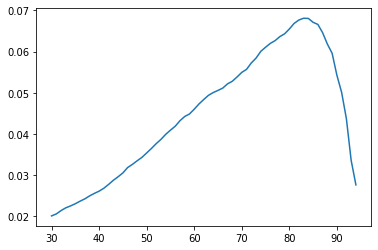

In [ ]:
for peptide in peptides_no_pka:
    for i, percentile in enumerate(percentiles):
        kin_to_p = get_probabilities_for_peptide(peptide, percentile)
        score = objective_function(kin_to_p)
        percentile_to_score[i] += (score)

percentile_to_score = [
                       score / Decimal(len(percentiles))
                       for score in percentile_to_score
]

plt.plot(percentiles, percentile_to_score)
print(percentile_to_score)


best_percentile = 0
best_percentile_score = -1

for i, percentile in enumerate(percentiles):
    if percentile_to_score[i] > best_percentile_score:
        best_percentile_score = percentile_to_score[i]
        best_percentile = percentile

print(best_percentile)


[Decimal('0.005169122004629755856643768057'), Decimal('0.005290101378100354568262218631'), Decimal('0.005482569048069086440549425268'), Decimal('0.005643259963085820147228496251'), Decimal('0.005746441925380247536941734518'), Decimal('0.005869082632811188453906553603'), Decimal('0.006026855524064926639749482645'), Decimal('0.006164416300446339549208073137'), Decimal('0.006345505670894117106638538608'), Decimal('0.006502614619238340414394221837'), Decimal('0.006641564579809040714317953788'), Decimal('0.006798980127297513371346757068'), Decimal('0.007015398773762951874255474672'), Decimal('0.007260000079406997744735574051'), Decimal('0.007473259756026441823321736309'), Decimal('0.007697133038574110843854946205'), Decimal('0.007999367812364652619550478829'), Decimal('0.008169435611441415773539777228'), Decimal('0.00837711381955096574652723298'), Decimal('0.008550943378804703679499210678'), Decimal('0.008759825533601965337963486806'), Decimal('0.008967778426681307583504589649'), Decimal('0

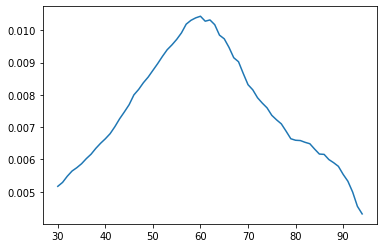

In [ ]:
for peptide in peptides_unclear:
    for i, percentile in enumerate(percentiles):
        kin_to_p = get_probabilities_for_peptide(peptide, percentile)
        score = objective_function(kin_to_p)
        percentile_to_score[i] += (score)

percentile_to_score = [
                       score / Decimal(len(percentiles))
                       for score in percentile_to_score
]

plt.plot(percentiles, percentile_to_score)
print(percentile_to_score)


best_percentile = 0
best_percentile_score = -1

for i, percentile in enumerate(percentiles):
    if percentile_to_score[i] > best_percentile_score:
        best_percentile_score = percentile_to_score[i]
        best_percentile = percentile

print(best_percentile)

In [ ]:
'''
For each
'''

from collections import Counter
NUM_INTEREST = 5

def get_kinase_to_rank(peptide, drop=None):
    kinase_to_probability = get_probabilities_for_peptide(peptide, best_percentile) if drop is None else get_probabilities_for_peptide_drop(peptide, percentile, drop)


    kinase_probability = [
                          (probability, kinase)
                          for kinase, probability in kinase_to_probability.items()
    ]

    kinase_probability.sort(reverse=True)
    kinase_to_rank = Counter({
        kinase: i + 1
        for i, (probability, kinase) in enumerate(kinase_probability)
    })

    return kinase_to_rank, [kinase for (probability, kinase) in kinase_probability][:NUM_INTEREST]


def get_probabilities_for_peptide_drop(peptide, percentile, drop_study):
    kinase_to_matching_scores = get_matching_1_mbf(peptide)

    kinase_to_scores_to_use = kinase_to_scores_read


    kinase_to_matching_scores_to_use = kinase_to_matching_scores

    if drop_study < 4:
        kinase_to_scores_to_use = {
            kinase: [score for i, score in enumerate(scores) if i != drop_study]
            for kinase, scores in kinase_to_scores_read.items()
        }

    elif drop_study < 6:
        index = drop_study - 4
        kinase_to_matching_scores_to_use = {
            kinase: [score for i, score in enumerate(scores) if i != index]
            for kinase, scores in kinase_to_matching_scores.items()
        }
    kinase_to_probability = calc_kinase_probability_score(percentile, kinase_to_scores_to_use, kinase_to_matching_scores_to_use)
    return kinase_to_probability

kinase_to_rank_initial = Counter()
drop_score = [0] * 7
for study in range(7):
    for peptide in peptide_to_direction:
        kinase_to_rank_expected, rank_expected = get_kinase_to_rank(peptide)
        kinase_to_rank_drop, rank_drop = get_kinase_to_rank(peptide, study)
        drop_change = 0

        for kinase in rank_expected:
            drop_change += abs(kinase_to_rank_expected[kinase] - kinase_to_rank_drop[kinase])

        drop_score[study] += drop_change



print(drop_score)

[2008, 2284, 4456, 2530, 2067, 10584, 4047]


Text(0.5, 1.0, 'Total rank changes of top 5 kinases for all peptides')

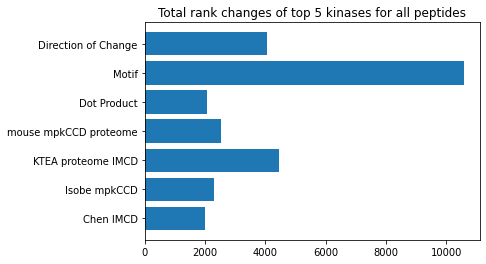

In [ ]:
study_labels = [
                "Chen IMCD",
                "Isobe mpkCCD",
                "KTEA proteome IMCD",
                "mouse mpkCCD proteome",
                "Motif",
                "Direction of Change",
                "Dot Product",
]

plt.barh(study_labels, drop_score)
plt.title(label="Total rank changes of top 5 kinases for all peptides")

In [ ]:
peptide_to_most_likely = {}

for peptide in peptide_to_direction:
    kinase_to_rank_expected, rank_expected = get_kinase_to_rank(peptide)
    peptide_to_most_likely[peptide] = rank_expected[0]

print(peptide_to_most_likely)

{'KGTPTQSPVVGRS': 'MAPK1', 'TQLTDLSPEEKTL': 'MAPK1', 'GLLSQVSPRLLRK': 'MAPK1', 'QSVELHSPQSLPR': 'MAPK1', 'DAISQKSVDIHDS': 'MAPK1', 'SSGVPYSPAIPNK': 'MAPK1', 'PLRKTASEPNLKL': 'CAMK2D', 'STKLDSSPVLSPG': 'MAPK1', 'KPVPITSPAVSKV': 'MAPK1', 'KFTRRVSVCAETF': 'PAK2', 'LLRERGTPPVDPK': 'MAPK1', 'LVRRSSSPAELDL': 'MAPK1', 'EVLGHKTPEPVPR': 'MAPK1', 'VEPASESPRPALA': 'MAPK1', 'VEKLPDSPALAKK': 'MAPK1', 'SSGSSGSPSSSVK': 'MAPK1', 'GGLAAGTPPLSRR': 'MAPK1', 'LSKARDSPPASSN': 'MAPK1', 'EVRRRQSVELHSP': 'PRKACA', 'LDPRRRSLPAGDA': 'PRKACA', 'SPPPDGSPAATPE': 'MAPK14', 'GGKKRDSLGTAGA': 'PRKACA', 'RLQDSRSLDGLSG': 'CSNK1A1', 'REERSLSAPGNLL': 'PRKACA', 'TMIRKRSFGNPFE': 'PRKACA', 'QNQRRFSMEDLNK': 'PRKACA', 'RYARKISGTTALQ': 'PRKACA', 'DTQRRTSMGGTQQ': 'PRKACA', 'QDTQRRTSMGGTQ': 'PRKACA', 'LVIKRASGPGTPP': 'PRKACA', 'LPEQRSSLPQQEL': 'PRKACA', 'NAARRDSVLAASR': 'PRKACA', 'PSGRRESLTSFGN': 'PRKACA', 'YFKGDHSVGVNGP': 'PRKACA', 'TKGRVSSFSMPSS': 'PRKACA', 'RRVRSGSGMSVIS': 'PRKACA', 'TSSRRGSGDTSIS': 'PRKACA', 'ESRRKGSLDYLKQ': 

In [ ]:
def get_single_peptide_sensitivity(peptide):
    kinase_percentiles = defaultdict(list)

    probabilities = get_probabilities_for_peptide(peptide, best_percentile)
    prob_kinase = [(probability, kinase) for kinase, probability in probabilities.items()]
    prob_kinase.sort(reverse=True)
    kinases_int = [kinase for _, kinase in prob_kinase[:NUM_INTEREST]]

    for percentile in percentiles:
        probabilities = get_probabilities_for_peptide(peptide, percentile)

        for kinase in kinases_int:
            kinase_percentiles[kinase].append(probabilities[kinase])

    return kinase_percentiles, kinases_int

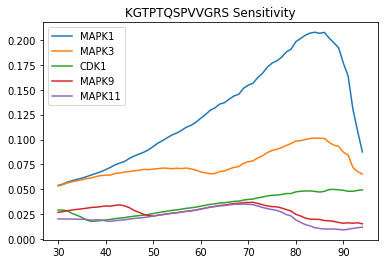

In [ ]:
kinase_percentiles, kinases_int = get_single_peptide_sensitivity("KGTPTQSPVVGRS")
for kinase in kinases_int:
    plt.plot(percentiles, kinase_percentiles[kinase], label=kinase)

plt.title("KGTPTQSPVVGRS Sensitivity")
plt.legend(loc="best")
plt.show()

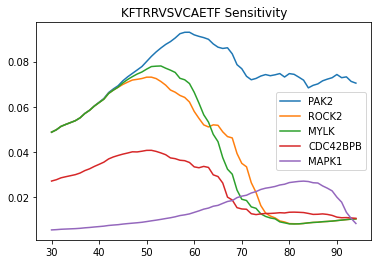

In [ ]:
kinase_percentiles, kinases_int = get_single_peptide_sensitivity("KFTRRVSVCAETF")
for kinase in kinases_int:
    plt.plot(percentiles, kinase_percentiles[kinase], label=kinase)

plt.title("KFTRRVSVCAETF Sensitivity")
plt.legend(loc="best")
plt.show()

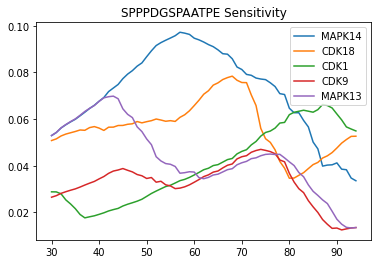

In [ ]:
kinase_percentiles, kinases_int = get_single_peptide_sensitivity("SPPPDGSPAATPE")
for kinase in kinases_int:
    plt.plot(percentiles, kinase_percentiles[kinase], label=kinase)

plt.title("SPPPDGSPAATPE Sensitivity")
plt.legend(loc="best")
plt.show()

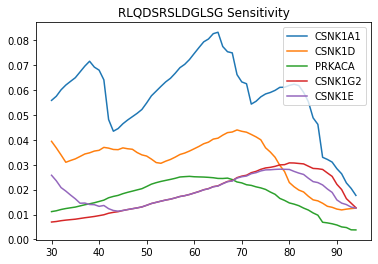

In [ ]:
kinase_percentiles, kinases_int = get_single_peptide_sensitivity("RLQDSRSLDGLSG")
for kinase in kinases_int:
    plt.plot(percentiles, kinase_percentiles[kinase], label=kinase)

plt.title("RLQDSRSLDGLSG Sensitivity")
plt.legend(loc="best")
plt.show()

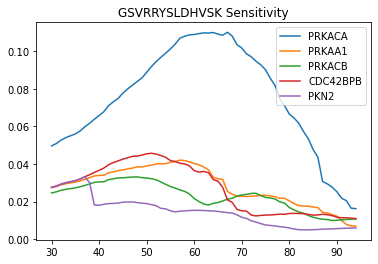

In [ ]:
kinase_percentiles, kinases_int = get_single_peptide_sensitivity("GSVRRYSLDHVSK")
for kinase in kinases_int:
    plt.plot(percentiles, kinase_percentiles[kinase], label=kinase)

plt.title("GSVRRYSLDHVSK Sensitivity")
plt.legend(loc="best")
plt.show()

In [ ]:
NUM_INTEREST = 5
def get_best_candidates(peptide):
    kinase_percentiles = defaultdict(list)

    probabilities = get_probabilities_for_peptide(peptide, best_percentile)
    prob_kinase = [(probability, kinase) for kinase, probability in probabilities.items()]
    prob_kinase.sort(reverse=True)
    kinases_int = [kinase for _, kinase in prob_kinase[:NUM_INTEREST]]

    return [
            (kinase, probabilities[kinase])
            for kinase in kinases_int
    ]

In [ ]:
peptide_probability_kinase = []

for peptide in peptide_to_direction:
    peptide_probability_kinase.append([peptide, get_best_candidates(peptide)])

print(peptide_probability_kinase)

[['KGTPTQSPVVGRS', [('MAPK1', Decimal('0.1464032542115748038068531233')), ('MAPK3', Decimal('0.07342260628364835015886279877')), ('CDK1', Decimal('0.03872444835850575897057070410')), ('MAPK9', Decimal('0.03651827835813292977067354818')), ('MAPK11', Decimal('0.03583083912183857938232329345'))]], ['TQLTDLSPEEKTL', [('MAPK1', Decimal('0.1452359868148583264578097787')), ('MAPK3', Decimal('0.07283721072698266203605203791')), ('CDK1', Decimal('0.03841569985241455366699361249')), ('MAPK9', Decimal('0.03621816346233645015884469002')), ('MAPK11', Decimal('0.03554136372191142929296675854'))]], ['GLLSQVSPRLLRK', [('MAPK1', Decimal('0.1464032504683962982562922882')), ('MAPK3', Decimal('0.07342260440640919217349764990')), ('CDK1', Decimal('0.03872444736841490671818034598')), ('MAPK9', Decimal('0.03651827742447085432594981292')), ('MAPK11', Decimal('0.03583083820573595869570653041'))]], ['QSVELHSPQSLPR', [('MAPK1', Decimal('0.1309723762268318566053181826')), ('MAPK3', Decimal('0.06568387612367883069

In [ ]:
fields = ['Peptide', 'First', 'Second', 'Third', "Fourth", "Fifth"]

rows = []

for peptide, best_candidates in peptide_probability_kinase:
    row = [peptide]

    for candidate, prob in best_candidates:
        row.append(f"{candidate} ({round(prob, 3)})")

    rows.append(row)

# name of csv file
filename = "peptide_best_candidates.csv"

# writing to csv file
with open(filename, 'w') as csvfile:
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)

    # writing the fields
    csvwriter.writerow(fields)

    # writing the data rows
    csvwriter.writerows(rows)